<a href="https://colab.research.google.com/github/mfavaits/YouTube-Series-on-Machine-Learning/blob/master/KNN_Logistic_Regression_and_Naive_Bayes_Pima_Indians_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Pima are a group of Native Americans living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, because of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity, made them develop the highest prevalence of type 2 diabetes and for this reason they have been subject of many studies.

The dataset includes data from 768 women with 8 features:


Number of times pregnant

Plasma glucose concentration a 2 hours in an oral glucose tolerance test

Diastolic blood pressure (mm Hg)

Triceps skin fold thickness (mm)

2-Hour serum insulin (mu U/ml)

Body mass index (weight in kg/(height in m)^2)

Diabetes pedigree function

Age (years)


The last column of the dataset indicates if the person has been diagnosed with diabetes (1) or not (0)


We will start with importing a few key libraries

In [0]:
import numpy as np #linear algebra library of Python
import pandas as pd # build on top of numpy for data analysis, data manipulation and data visualization
import matplotlib.pyplot as plt #plotting library of Python

Now let's mount Google drive so that we can upload the diabetes.csv file. You can find the code in the 'Code snippets' tab of Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


First thing that we do is take a look at the shape of the dataframe (df.shape) and take a look at first 5 lines through df.head()

In [0]:
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/diabetes.csv') #import file from Google Drive and create a pandas dataframe df
df.head() #shows first 5 lines including column namesdf.shape # number of rows and columns of dataframe

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
df.shape # provides # rows and # columns of the dataframe df - 768 rows and 9 columns

(768, 9)

Now we will assess if the dataset has the same proportion of diabetes vs. non-diabetes cases.
At the same time we will look if there are missing values. In our dataset we note that woman #2 has a skin thickness of zero and this is not realistic. It leads us to believe that there are a few zero entries that signal that no data was available. This does not apply to columns columns 1 and 9 for obvious reasons.

We use a trick to count the non-zero values of the columns. We convert the data type of the dataframe df to to Boolean using df.astype(bool) coverting all zero values to false=0 and all other entries to true=1 . We subsequently add up all True entries per column.

In [0]:
df.astype(bool).sum(axis=0) # counts the number of non-zeros for each column while acting on all rows - default value is True(1) so all 1s are added per column

Pregnancies                 657
Glucose                     763
BloodPressure               733
SkinThickness               541
Insulin                     394
BMI                         757
DiabetesPedigreeFunction    768
Age                         768
Outcome                     268
dtype: int64

The dataframe is unbalanced as we have 268 ones (diabetes) and thus 500 zeros (no diabetes). 

The easiest option could be to eliminate all those patients with zero values, but in this way we would eliminate a lot of important data.

Another option is to calculate the median value for a specific column and substitute the zero values for the columns by that median value.

In [0]:
df.head() #shows first 5 lines including column names

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The skin thickness of woman #2 is now 23 (median of that column)

Let's create numpy arrays, one for the features (X) and one for the label (y)



In [0]:
X=df.drop('Outcome', axis=1).values #drop 'Outcome' column but you keep the index column
y=df['Outcome'].values

We import the train_test_split function from sklearn to split the arrays or matrices into random train and test subsets>

Parameters:	
test_size : in our case 20% (default=0.25)

random_state: is basically used for reproducing your problem the same every time it is run. If you do not use a random_state in train_test_split, every time you make the split you might get a different set of train and test data points and will not help you in debugging in case you get an issue. We used random_state=42 but number does not matter

stratify : array-like or None (default=None)
If the number of values belonging to each class are unbalanced, using stratified sampling is a good thing. You are basically asking the model to take the training and test set such that the class proportion is same as of the whole dataset, which is the right thing to do.

In [0]:
from sklearn.model_selection import train_test_split #method to split training and testing data sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

The last preprocessing step is feature normalization transforming the data to have mean=0 and standard deviation=1. It is good practice and since we use distance as the similarity measure in KNN we should not forget this step.

In [0]:
from sklearn.preprocessing import StandardScaler 
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [0]:
print(X_train)

[[-0.85135507 -0.98013068 -0.40478372 ... -0.60767846  0.31079384
  -0.79216928]
 [ 0.35657564  0.16144422  0.46536842 ... -0.30213902 -0.11643851
   0.56103382]
 [-0.5493724  -0.50447447 -0.62232176 ...  0.3725939  -0.76486207
  -0.70759409]
 ...
 [-0.85135507 -0.75815778  0.03029235 ...  0.77997981 -0.78607218
  -0.28471812]
 [ 1.86648903 -0.31421198  0.03029235 ... -0.56948603 -1.01938346
   0.56103382]
 [ 0.05459296  0.73223168 -0.62232176 ... -0.31486983 -0.57700104
   0.30730824]]


Now we are ready to use the KNN algorithm

In [0]:
from sklearn.neighbors import KNeighborsClassifier # we import the K-Nearest Neighbor Classifier
neighbors=np.arange(1,20) #we will try different k - default step size is 1 - returns evenly spaced values within a given interval excl 20

train_accuracy=np.empty(len(neighbors)) # creates an array that will be used for storing training accuracy
test_accuracy=np.empty(len(neighbors))  # creates an array that will be used for storing testing accuracy

In [0]:
print(neighbors)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


A lot of times when dealing with iterators, we also get a need to keep a count of iterations. Python eases the programmers’ task by providing a built-in function enumerate() for this task.
Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. This enumerate object can then be used directly in 'for loops' or be converted into a list of tuples using list() method.

In [0]:
for i,k in enumerate(neighbors): #k goes from 1 to 19 en i is de counter
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  train_accuracy[i]=knn.score(X_train, y_train)
  test_accuracy[i]=knn.score(X_test, y_test)

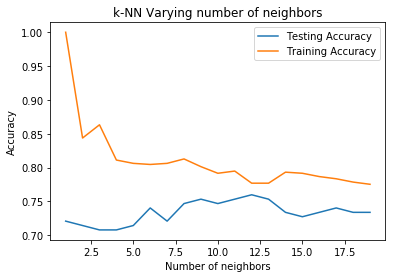

In [0]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We get maximum testing accuracy for k=8, so we will setup a KNN classifier with hyperparameter k=8 (we will look at 8 neighbors in order to decide on the label of a test point)

In [0]:
knn=KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
knn.score(X_test, y_test) #score method represents accuracy

0.7467532467532467

Now we will look at other classification KPIs that we discussed in our lessons: Confusion Matrix, ROC, AUC, F1-Score

In [0]:
from sklearn.metrics import confusion_matrix
y_pred=knn.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[88, 12],
       [27, 27]])

Classifier not so good: true positives=26, true negatives=92, false positives=8 and false negatives=28. We cannot accept the numerous False Negatives (FNs) in this case as we would tell a women that she is not diabetic whereas she actually is diabetic. One option to reduce the FNs is to change the threshold of the classifier but this will increase the amount of False Positives (FPs) as we have seen in lesson 3. Recall in our case is TP/(TP+FN) = 48% and this is too high. Precission is TP/(TP+FP)=77%

ROC (Receiver Operating Characteristic) curve

It is a plot of Recall vs. False Positive Rate (FPR) for the different possible thresholds of the classifier. It shows the tradeoff between Recall and Precision. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. The area under the curve is a measure of test accuracy.

In [0]:
from sklearn.metrics import roc_curve
y_pred_proba=knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds=roc_curve(y_test, y_pred_proba)

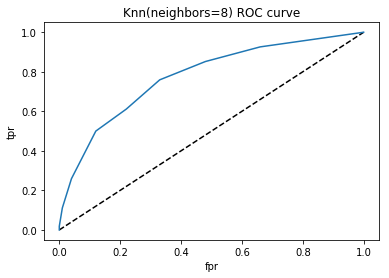

In [0]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(neighbors=8) ROC curve')
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score #area under the ROC curve
roc_auc_score(y_test, y_pred_proba)

0.7757407407407408

Cross Validation

Now before getting into the details of Hyperparamter tuning, let us understand the concept of Cross validation.

The trained model's performance is dependent on way the data is split. It might not representative of the model’s ability to generalize.

The solution is cross validation.

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once

(Kilian Weinberger explains this)

Hyperparameter tuning

The value of k (i.e 7) we selected above was selected by observing the curve of accuracy vs number of neighbors. This is a primitive way of hyperparameter tuning.

There is a better way of doing it which involves:

1) Trying a bunch of different hyperparameter values

2) Fitting all of them separately

3) Checking how well each performs

4) Choosing the best performing one

5) Using cross-validation every time

Scikit-learn provides a simple way of achieving this using GridSearchCV i.e Grid Search cross-validation.

Let's see what accuracy we get using logistics regression and naive Bayes

In [0]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7077922077922078


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is only 74%, same as KNN


Now SVM

In [0]:
from sklearn import svm

In [0]:
clf = svm.SVC(kernel='linear') # Linear Kernel

In [0]:
clf.fit(X_train, y_train)
score=clf.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7142857142857143


Also 74%...a bit strange that all classifiers have the same accuracy